In [21]:
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector


Comenzamos almacenando en variables los diferentes métodos de ejecución del circuito para su posterior uso:

In [22]:
backend_unitary = Aer.get_backend('unitary_simulator')
backend_qasm = Aer.get_backend('qasm_simulator')
backend_stvec = Aer.get_backend('statevector_simulator')
backend_sim = Aer.get_backend('aer_simulator')

Comenzamos construyendo el circuito donde los qbits $q_0$ y $q_1$ se corresponden con Alice, mientras que el qbit $q_2$ será para Bob.

In [23]:
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

A continuación, vamos a inicializar el qubit $q_0$. Para ello le asignaremos un valor aleatorio como vector de estados. Nuestro objetivo será ver que dicho valor se transporta correctamente al qubit $q_2$.

In [24]:
#Sacamos un vector aleatorio que inicialice el qbit q0
init_value = random_statevector(2)

#Creamos la puerta que inicializará el qbit
init_gate = Initialize(init_value)
init_gate.label = "init_value"

#Añadimos el la puerta que inicializa el qbit q0 a nuestro circuito
circuit.append(init_gate, [0])
circuit.barrier()

El valor con el cuál inicializamos $q_0$ será el siguiente

In [25]:
display(array_to_latex(init_value, prefix="|\\psi\\rangle ="))

<IPython.core.display.Latex object>

Para el segundo y tercer qbit será necesario aplicar en estado de Bell. Para ello introduciremos una puerta de Hadamard y otra CNOT en este orden.

In [26]:
circuit.h(qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])

circuit.draw()

┌────────────────────────────────────────────────┐ ░           
q_0: ┤ init_value(0.74023+0.48918j,0.45525-0.074296j) ├─░───────────
     └────────────────────────────────────────────────┘ ░ ┌───┐     
q_1: ───────────────────────────────────────────────────░─┤ H ├──■──
                                                        ░ └───┘┌─┴─┐
q_2: ───────────────────────────────────────────────────░──────┤ X ├
                                                        ░      └───┘
c_0: ═══════════════════════════════════════════════════════════════
                                                                    
c_1: ═══════════════════════════════════════════════════════════════

A continuación, para poder llevar a cabo el algoritmo de teleportación, aplicamos en los qbits pertenecientes a Alice una transformación de la siguiente manera: una puerta CNOT para $q_0$ y $q_1$, y una de Hadamard para el qbit $q_0$.

In [27]:
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])

El circuito quedará de la siguiente forma:

In [28]:
circuit.draw()

┌────────────────────────────────────────────────┐ ░            ░      »
q_0: ┤ init_value(0.74023+0.48918j,0.45525-0.074296j) ├─░────────────░───■──»
     └────────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐»
q_1: ───────────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├»
                                                        ░ └───┘┌─┴─┐ ░ └───┘»
q_2: ───────────────────────────────────────────────────░──────┤ X ├─░──────»
                                                        ░      └───┘ ░      »
c_0: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_1: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───┐
«q_0: ┤ H ├
«     └───┘
«q_1: ─────
«          
«q_2: ─────
«          
«c_0: ═════
«          
«c_1: ═════
«

Veamos la matriz que interviene en nuestro circuito.

In [29]:
unitary= execute(circuit,backend_unitary,shots=1024).result().get_unitary()
array_to_latex(unitary)


<IPython.core.display.Latex object>

Y este será el vector de estados final, tras aplicarse dicha parte del algoritmo:

In [30]:
final_state= execute(circuit,backend_stvec,shots=1024).result().get_statevector()
array_to_latex(final_state)

<IPython.core.display.Latex object>

Introducimos dos medidores para $q_0$ y $q_1$ y una barrera para separar el circuito de dichos medidores.

In [31]:
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])

circuit.draw()

┌────────────────────────────────────────────────┐ ░            ░      »
q_0: ┤ init_value(0.74023+0.48918j,0.45525-0.074296j) ├─░────────────░───■──»
     └────────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐»
q_1: ───────────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├»
                                                        ░ └───┘┌─┴─┐ ░ └───┘»
q_2: ───────────────────────────────────────────────────░──────┤ X ├─░──────»
                                                        ░      └───┘ ░      »
c_0: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_1: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───┐ ░ ┌─┐   
«q_0: ┤ H ├─░─┤M├───
«     └───┘ ░ └╥┘┌─┐
«q_1: ──────░──╫─┤M├
«           ░  ║ └╥┘
«q_2: ──────░──╫──╫─
«           ░  ║  ║ 
«c_0: ═════════╩══╬═
«                 ║ 
«c_1: ════════════╩═
«

Por último, para descodificar la información transmitida al qbit $q_2$, aplicaremos dos condicionales a las puertas NOT y Z. De modo que si tienen valor 1 se aplicarán al estado. De modo que se siga el esquema siguiente:

$$
00 \longrightarrow \text{no se aplica ninguna puerta cuántica}
$$
$$
01 \longrightarrow \text{se aplica la puerta cuántica  } X
$$
$$
10 \longrightarrow \text{se aplica la puerta cuántica  } Z
$$
$$
11 \longrightarrow \text{se aplican las puertas cuánticas  } XZ
$$

In [32]:
circuit.barrier(qreg_q[0], qreg_q[1],qreg_q[2])
circuit.x(2).c_if(creg_c[1], 1) 
circuit.z(2).c_if(creg_c[0], 1)

circuit.draw()

┌────────────────────────────────────────────────┐ ░            ░      »
q_0: ┤ init_value(0.74023+0.48918j,0.45525-0.074296j) ├─░────────────░───■──»
     └────────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐»
q_1: ───────────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├»
                                                        ░ └───┘┌─┴─┐ ░ └───┘»
q_2: ───────────────────────────────────────────────────░──────┤ X ├─░──────»
                                                        ░      └───┘ ░      »
c_0: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_1: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───┐ ░ ┌─┐    ░           
«q_0: ┤ H ├─░─┤M├────░───────────
«     └───┘ ░ └╥┘┌─┐ ░           
«q_1: ──────░──╫─┤M├─░───────────
«           ░  ║ └╥┘ ░ ┌───┐┌───┐
«q_2: ──────░──╫──╫──░─┤ X ├┤ Z ├
«           ░  ║  ║  ░ └─╥─┘└─╥─┘
«c_0: ═════════╩══╬══════╬════■══
«                 ║      ║       
«c_1: ════════════╩══════■═══════
«

El vector inicial correspondiente a la información que quería transmitir Alice era el siguiente:

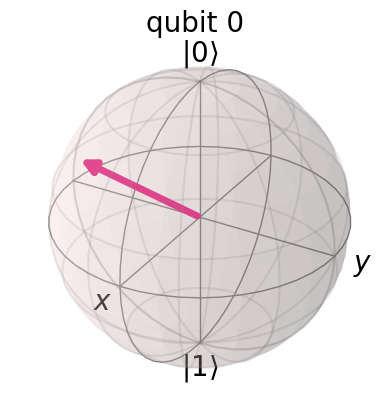

In [33]:
plot_bloch_multivector(init_value)

Comparándolo con los estados finales de los tres qbits, vemos que se ha transmitido correctamente al qbit $q_2$.

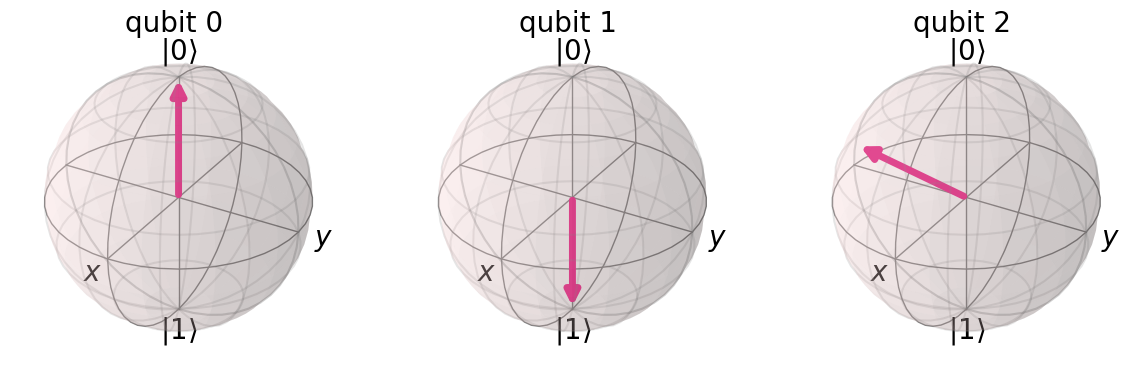

In [34]:

circuit.save_statevector()
out_vector = backend_sim.run(circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

In [35]:
circuit.data.pop(13) #borramos el vector de estados almacenado en nuestro circuito

CircuitInstruction(operation=Instruction(name='save_statevector', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

In [36]:
circuit.barrier(qreg_q[0], qreg_q[1],qreg_q[2])
inverse_init = init_gate.gates_to_uncompute()
circuit.append(inverse_init, [2])

cr_result = ClassicalRegister(1)
circuit.add_register(cr_result)
circuit.measure(2,2)


In [16]:
circuit.draw()

┌──────────────────────────────────────────┐ ░            ░      ┌───┐ ░ »
q_0: ┤ init(-0.4951-0.15589j,-0.79367-0.31727j) ├─░────────────░───■──┤ H ├─░─»
     └──────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ »
q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─»
                                                  ░ └───┘┌─┴─┐ ░ └───┘      ░ »
q_2: ─────────────────────────────────────────────░──────┤ X ├─░────────────░─»
                                                  ░      └───┘ ░            ░ »
c_0: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_1: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
 c0: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌─┐    ░            ░                    
«q_0: ┤M├────░────────────░────────────────────
«     └╥┘┌─┐ ░            ░                    
«q_1: ─╫─┤M├─░────────────░────────────────────
«      ║ └╥┘ ░ ┌───┐┌───┐ ░ ┌──────────────┐┌─┐
«q_2: ─╫──╫──░─┤ X ├┤ Z ├─░─┤ disentangler ├┤M├
«      ║  ║  ░ └─╥─┘└─╥─┘ ░ └──────────────┘└╥┘
«c_0: ═╩══╬══════╬════■══════════════════════╬═
«         ║      ║                           ║ 
«c_1: ════╩══════■═══════════════════════════╬═
«                                            ║ 
« c0: ═══════════════════════════════════════╩═
«

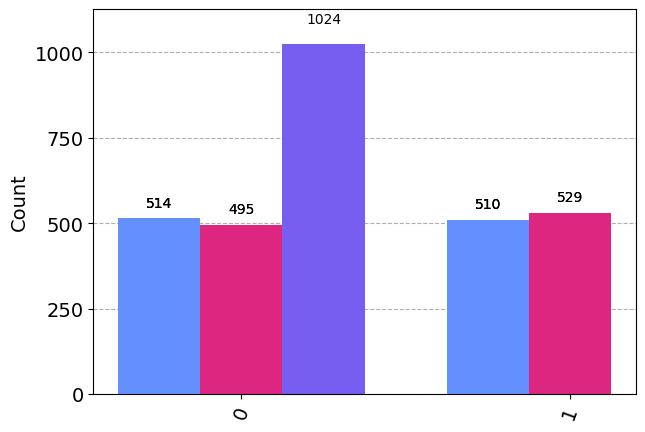

In [42]:
sim = Aer.get_backend('aer_simulator')
from qiskit.ignis.verification import marginal_counts

t_qc = transpile(circuit, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

Veamos ahora desde un punto de vista gráfico, el valor que adopta el vector de estados:

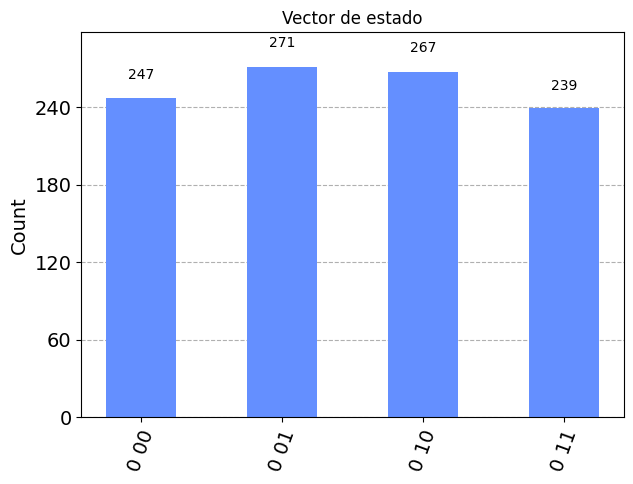

In [43]:
job = execute(circuit, backend_qasm, shots=1024)

plot_histogram(job.result().get_counts(), title="Vector de estado")